Importing libraries and toolkit with all necessary functions, definitions

In [122]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import ipywidgets as widgets
import statsmodels.api as sm
import seaborn as sns
from scipy.optimize import minimize
from numpy.linalg import inv
import toolkit as kit
%load_ext autoreload
%autoreload 2
%matplotlib inline
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Time value of money | Cumulative Present Value

The cumulative present value (PV) of future cash flows can be calculated by summing the contributions of future values 
FV, i.e., the value of cash flow at time t .

In [133]:
# Suppose we want to know the PV of 1 dollar paid in 10 years at an annual interest rate of 3%:
PV = kit.discount(10, 0.03)
PV

,0
10,0.744094


In [136]:
# that is, PV = 0.74 cents will be FV = 1 in 10 years (considering r = 3%). In fact:
FV = PV * (1+0.03)**10
FV

,0
10,1.0


current liabilities separated into 3 main groups (death, 1st rank, 2nd rank)

In [145]:
L = pd.DataFrame([[70,3,9],[231,7,28],[236,9,25]], index=[1,2,3])
L

,0,1,2
1,70,3,9
2,231,7,28
3,236,9,25


In [146]:
L.sum()

0    537
1     19
2     62
dtype: int64

In [147]:
r = [0.05, 0.04,0.03] 
PV = kit.present_value(L, r)
PV

0    480.056149
1     17.357476
2     58.009091
dtype: float64

the present value of liabilities of 618 $ mln USD are now valued at 480,17,58 respectively with the given interest rate

# Funding ratio
The funding ratio is a simply ratio between the value of assets I currently hold and the present value of our liability:

In [150]:
asset = [420,15,65] 
FR = kit.funding_ratio(asset, L, r)
FR

0    0.874898
1    0.864181
2    1.120514
dtype: float64

In [153]:
def show_funding_ratio(asset, L, r):
    fr = kit.funding_ratio(asset, L, r)
    print("Funding ratio: {:.3f}".format(float(fr)))
    
    fig, ax = plt.subplots(1,2,figsize=(15,3))
    ax[0].scatter(r, fr)
    ax[0].set_xlabel("rates")
    ax[0].set_ylabel("funding ratio")
    ax[0].set_xlim([0.0, 0.06])
    ax[0].set_ylim([0.70, 1.5])
    ax[0].plot([r,r],[0,fr], color="b", alpha=0.5)
    ax[0].plot([0,r],[fr,fr], color="b", alpha=0.5)
    ax[0].grid()
    
    ax[1].scatter(asset, fr)
    ax[1].set_xlabel("assets")
    ax[1].set_ylabel("funding ratio")
    ax[1].set_xlim([10, 800])
    ax[1].set_ylim([0.70, 1.5])
    ax[1].plot([asset,asset],[0,fr], color="b", alpha=0.5)
    ax[1].plot([0,asset],[fr,fr], color="b", alpha=0.5)
    ax[1].grid()

Funding ratio: 1.052


C:\Users\Feliks.Chilingaryan\Anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


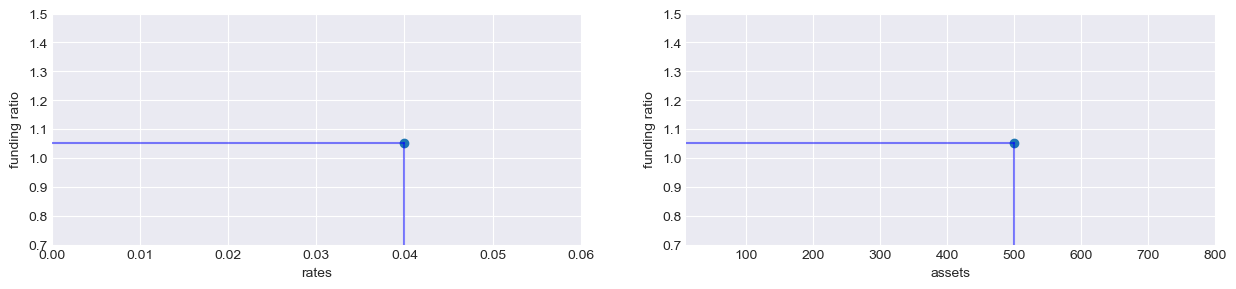

In [156]:
r     = 0.04
asset = 500
L     = pd.DataFrame([420, 15,65],index=[1,2,3])

show_funding_ratio(asset, L, r)

# Nominal, effective interest rate and compounding

We will see that due to compounding, the more payments due over the entire period the larger the total compound return, hence more money have to be paid back. So, as soon as the number of payments increase, we have the convergence

In [157]:
# Consider a nominal interest rate of 10% and monthly payments
nominal_rate = 0.1
periods_per_year = 12

# that is, every month, we have the following rates
rets = pd.DataFrame( [nominal_rate/periods_per_year for i in range(10)] )
rets.head(3)

,0
0,0.008333
1,0.008333
2,0.008333


In [158]:
ann_ret = kit.annualize_rets(rets, periods_per_year)[0]
ann_ret

0.1047130674412966

In [159]:
R = (1 + nominal_rate / periods_per_year)**periods_per_year - 1
R

0.10471306744129683

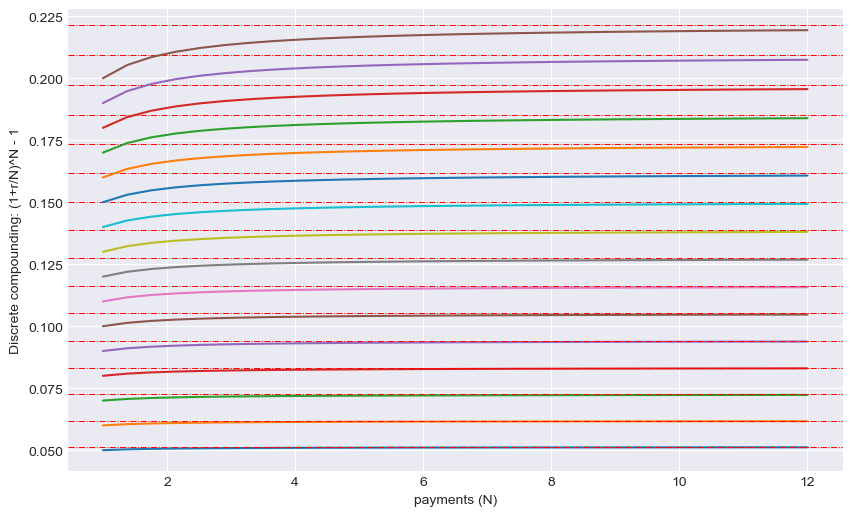

In [173]:
N = np.linspace(1,12,30)
nom_rates = np.arange(0.05,0.2,0.01)
fig, ax = plt.subplots(1,1,figsize=(10,6))
for r in nom_rates:
    ax.plot(N, (1 + r / N)**N - 1)
    ax.axhline(y=np.exp(r) -  1, color="r", linestyle="-.", linewidth=0.7)
    ax.set_ylabel("Discrete compounding: (1+r/N)^N - 1")
    ax.set_xlabel("payments (N)")
plt.grid()

In [176]:
# discrete compounding 
r = 0.1
R_disc = kit.compounding_rate(r, periods_per_year=12)
R_disc

0.10471306744129683

In [182]:
# continuously compounding 
r = 0.1
R_cont = kit.compounding_rate(r)
R_cont

0.10517091807564771

In [183]:
# get the discrete compounded rate above and return back the nominal rate of 0.1 
kit.compounding_rate_inv( R_disc, periods_per_year=12)

0.09999999999999964

In [184]:
# get the continuously compounded rate above and return back the nominal rate of 0.1 
kit.compounding_rate_inv( R_cont ) 

0.10000000000000007

# CIR model: simulate changes in interest rates
The CIR model (from Cox, Ingersoll, Ross) is used to simulate changes in interest rates (returns) and it is an extension of the Vasicek model to prevent negative interest rates. It is a type of one factor model, or short-rate model, as it describes interest rate movements as driven by only one source of market risk. The model can be used in the valuation of interest rate derivatives.

In [187]:
def show_cir(n_years=20, n_scenarios=10, a=0.05, b=0.05, sigma=0.04, periods_per_year=12, r0=None):
    rates, zcb_price = kit.simulate_cir(n_years=n_years, n_scenarios=n_scenarios, a=a, b=b, sigma=sigma, periods_per_year=periods_per_year, r0=r0)
    
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    rates.plot(ax=ax[0], grid=True, title="CIR model: interest rates", color="indianred", legend=False)
    zcb_price.plot(ax=ax[1], grid=True, title="CIR model: ZCB price", color="indianred", legend=False)

cir_controls = widgets.interact(show_cir, 
                                n_years = (1, 20, 1), 
                                n_scenarios = (1, 200, 1), 
                                a = (0.005, 1, 0.005), 
                                b = (0.002, 0.15, 0.001), 
                                sigma = (0.001, 0.15, 0.001), 
                                periods_per_year = [12, 52, 252], 
                                r0 = (0.002, 0.30, 0.01)
                               )

interactive(children=(IntSlider(value=20, description='n_years', max=20, min=1), IntSlider(value=10, descripti…

# Liability hedging

Since we have a model to simulate interest rates and changes in the price of zero-coupon bonds we can see what happens to the hedging strategy in case we use zero-coupon bonds as hedge instead of cash.

We have seen that changes in interest rates has enormous impact on the liabilities we may have for the next future, and therefore, on the funding ratios. Hence it makes sense to make sure that we know how the portfolio is going to behave as interest rates fluctuate over time.

The problem is: we have some liability to satisfy in the future, and as long as interest rates changes over times, we have to make sure to meet such a liability by using a hedging strategy so that an increase in value of our asset will be enough.

In [188]:
asset_0  = 100
tot_liab = 620

mean_rate = 0.10
n_years   = 18
n_scenarios = 10
periods_per_year = 12

We have an initial amount of 100 million dollars(asset_0) and total liabilities of 620 million dollars(tot_liab) due in 18 years. Suppose that the mean rate of liability is 10%

In [189]:
rates, zcb_price = kit.simulate_cir(n_years=n_years, n_scenarios=n_scenarios, 
                                    a=0.05, b=mean_rate, sigma=0.08, periods_per_year=periods_per_year)
rates.head()

,0,1,2,3,4,5,6,7,8,9
0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,0.103262,0.090093,0.109469,0.108520,0.108733,0.099675,0.098501,0.108557,0.085431,0.092718
2,0.100990,0.077707,0.107731,0.119261,0.102842,0.108572,0.103903,0.107207,0.080015,0.087254
3,0.093203,0.083227,0.099389,0.114421,0.098128,0.119605,0.099688,0.103016,0.075796,0.074334
4,0.096384,0.072452,0.093228,0.105154,0.106564,0.127560,0.117000,0.110342,0.077402,0.085342


Furthermore, let us suppose that our liabilities over time are given by the zero-coupon bond prices that we have just simulated. This is going to be simply a trick to have changes in the liability according to the change in interest rates:

In [195]:
L = zcb_price
L.head()

,0,1,2,3,4,5,6,7,8,9
0,0.225411,0.225411,0.225411,0.225411,0.225411,0.225411,0.225411,0.225411,0.225411,0.225411
1,0.226696,0.226696,0.226696,0.226696,0.226696,0.226696,0.226696,0.226696,0.226696,0.226696
2,0.221477,0.249103,0.209642,0.211407,0.211008,0.228651,0.231055,0.211336,0.259777,0.243305
3,0.227287,0.280081,0.214126,0.193521,0.223585,0.212546,0.221494,0.215120,0.274287,0.256953
4,0.244980,0.267896,0.231862,0.203094,0.234471,0.194106,0.231246,0.224529,0.286501,0.290328


Hedging by buying zero-coupon bonds

Our task is meet the liability in 18 years. The idea is to invest our current asset in a zero-coupon bond.

We know what is the price of a zero-coupon bond that matures in 18 years. Since, by definition, such bond does not pay coupons and simply returns at maturity the face value plus the given interest, its price is simply given by the present value of this last amount:

In [196]:
# price of a zcb with maturity 18 years and rate equal to the mean rate
zcb = pd.DataFrame(data=[tot_liab], index=[n_years])
zcb_price_0 = kit.present_value(zcb, mean_rate )
zcb_price_0

0    111.51245
dtype: float64

i.e., a zero-coupon bond paying off 620 million dollars plus an interest of 10% in 18 years is worth about 111.5 million dollars today.

Hence, suppose we invest into such zero-coupon bond. First of all, given our initial asset, we can buy today the following number of bonds:

In [205]:
n_bonds = float(asset_0 / zcb_price_0)
n_bonds

0.8967608570148774

0.89x such bond, and since we know how interest rates will change over time, we also know the future value of our asset that have been invested in this zero-coupon bond. In fact, we know how many bonds we buy and how the price will change. Then:

In [221]:
asset_value_of_zcb = n_bonds * zcb_price
asset_value_of_zcb.head()

,0,1,2,3,4,5,6,7,8,9
0,0.202139,0.202139,0.202139,0.202139,0.202139,0.202139,0.202139,0.202139,0.202139,0.202139
1,0.203292,0.203292,0.203292,0.203292,0.203292,0.203292,0.203292,0.203292,0.203292,0.203292
2,0.198612,0.223386,0.187998,0.189581,0.189223,0.205045,0.207201,0.189518,0.232957,0.218187
3,0.203822,0.251166,0.192020,0.173542,0.200502,0.190603,0.198627,0.192911,0.245970,0.230426
4,0.219689,0.240238,0.207925,0.182127,0.210264,0.174067,0.207372,0.201349,0.256923,0.260355


Hedging by investing in cash

Suppose now that instead of putting our money in zero-coupon bonds we just put our money in cash. What is the future value of our asset then?

In [235]:
# we have to divide by periods_per_year since rates are returned as annual rates
asset_value_in_cash = asset_0 * (1 + rates/periods_per_year).cumprod()
asset_value_in_cash.head()

,0,1,2,3,4,5,6,7,8,9
0,100.833333,100.833333,100.833333,100.833333,100.833333,100.833333,100.833333,100.833333,100.833333,100.833333
1,101.701022,101.590364,101.753180,101.745199,101.746996,101.670880,101.661012,101.745515,101.551187,101.612426
2,102.556925,102.248218,102.666681,102.756387,102.618988,102.590762,102.541254,102.654501,102.228320,102.351267
3,103.353476,102.957371,103.517006,103.736176,103.458138,103.613289,103.393101,103.535759,102.874031,102.985283
4,104.183609,103.578996,104.321233,104.645197,104.376881,104.714695,104.401187,104.487785,103.537586,103.717696


Result:Comparing the two investments

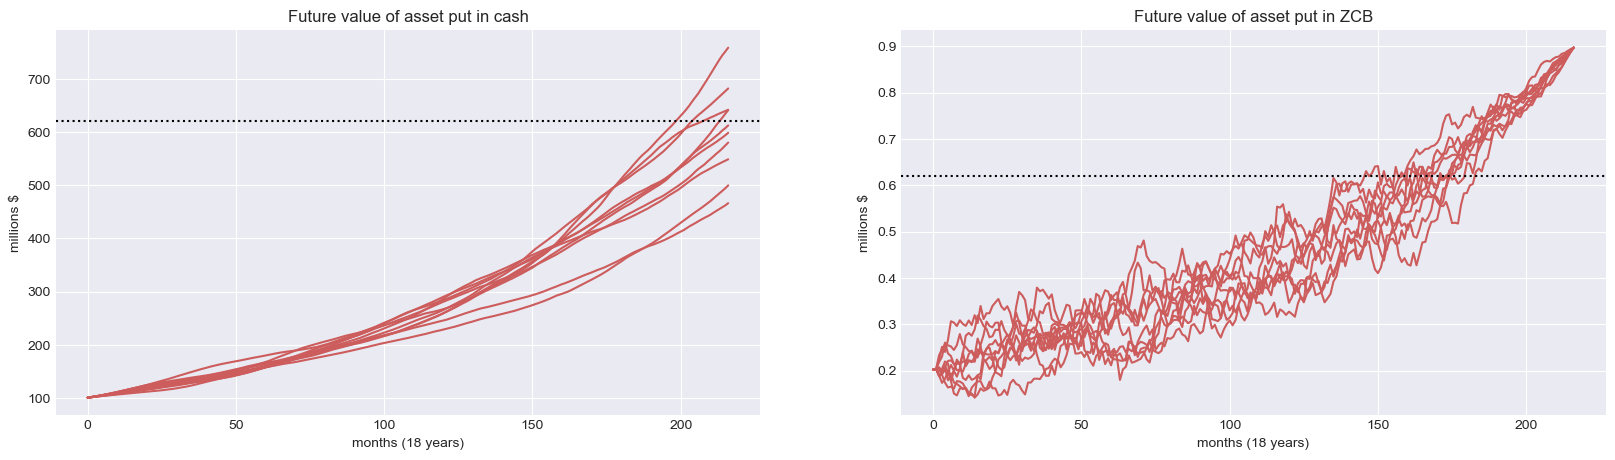

In [261]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

asset_value_in_cash.plot(ax=ax[0], grid=True, legend=False, color="indianred", title="Future value of asset put in cash")
asset_value_of_zcb.plot(ax=ax[1], grid=True, legend=False, color="indianred", title="Future value of asset put in ZCB")
ax[0].axhline(y=620.0, linestyle=":", color="black")
ax[1].axhline(y=0.62, linestyle=":", color="black")
ax[0].set_ylabel("millions $")
ax[1].set_ylabel("millions $")
if periods_per_year == 12:
    ax[0].set_xlabel("months ({:.0f} years)".format((len(asset_value_in_cash.index)-1)/periods_per_year))
    ax[1].set_xlabel("months ({:.0f} years)".format((len(asset_value_in_cash.index)-1)/periods_per_year))

plt.show()

We see that, although the increase in value in the left-hand side plot is smoother, there have been some scenarios in which the investment of our asset value in cash did not provide the  million dollars of liability that we have to pay.

On the other hand, notheless the oscillation in value, the investment in the zero-coupon bond always guarantee the money we need at the maturitWe see that, although the increase in value in the left-hand side plot is smoother, there have been some scenarios in which the investment of our asset value in cash did not provide the  million dollars of liability that we have to pay.

On the other hand, notheless the oscillation in value, the investment in the zero-coupon bond always guarantee the money we need at the maturit


In [262]:
fr_cash = asset_value_in_cash / L
fr_zcb  = asset_value_of_zcb  / L

In [260]:
fr_zcb

,0,1,2,3,4,5,6,7,8,9
0,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761
1,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761
2,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761
3,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761
4,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761
...,...,...,...,...,...,...,...,...,...,...
212,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761
213,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761
214,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761
215,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761,0.896761


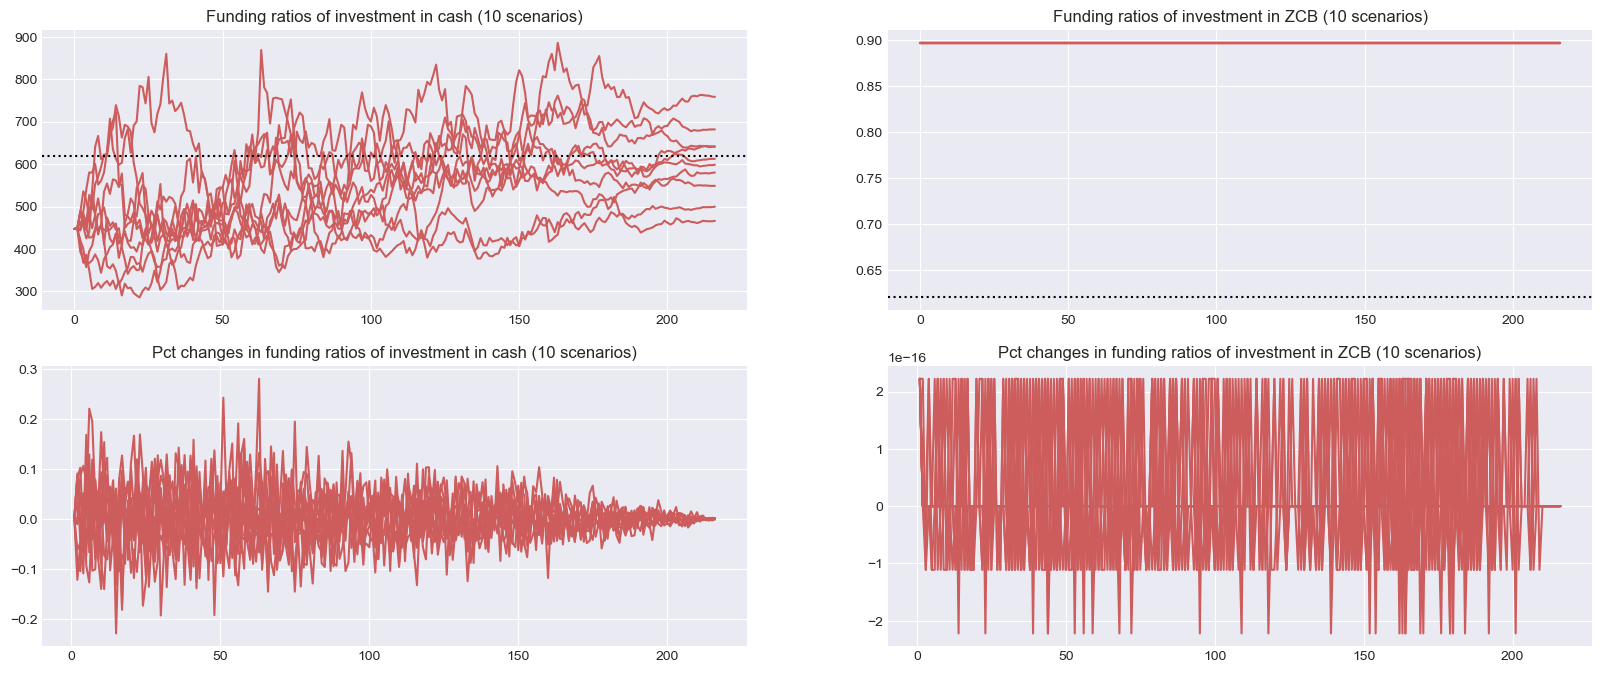

In [259]:
fig, ax = plt.subplots(2,2,figsize=(20,8))

fr_cash.plot(ax=ax[0,0], grid=True, legend=False, color="indianred", 
             title="Funding ratios of investment in cash ({} scenarios)".format(n_scenarios))
fr_zcb.plot(ax=ax[0,1], grid=True, legend=False, color="indianred", 
            title="Funding ratios of investment in ZCB ({} scenarios)".format(n_scenarios))

ax[0,0].axhline(y=620.0, linestyle=":", color="black")
ax[0,1].axhline(y=0.62, linestyle=":", color="black")

fr_cash.pct_change().plot(ax=ax[1,0], grid=True, legend=False, color="indianred",
                          title="Pct changes in funding ratios of investment in cash ({} scenarios)".format(n_scenarios))
fr_zcb.pct_change().plot(ax=ax[1,1], grid=True, legend=False, color="indianred", 
                         title="Pct changes in funding ratios of investment in ZCB ({} scenarios)".format(n_scenarios))
plt.show()

Terminal funding ratio results

In [272]:
# simulate more scenarios
n_scenarios = 5000
rates, zcb_price = kit.simulate_cir(n_years=n_years, n_scenarios=n_scenarios, a=0.05, 
                                    b=mean_rate, sigma=0.08, periods_per_year=periods_per_year)
# assign liabilities
L = zcb_price
# ZCB investment:
zcb = pd.DataFrame(data=[tot_liab], index=[n_years])
zcb_price_0 = kit.present_value( zcb, mean_rate )
n_bonds = float(asset_0 / zcb_price_0)
asset_value_of_zcb = n_bonds * zcb_price
# Cash investment 
asset_value_in_cash = asset_0 * (1 + rates/periods_per_year).cumprod()

In [279]:
# terminal funding ratios
terminal_fr_zcb  = asset_value_of_zcb.iloc[-1]  / L.iloc[-1]
terminal_fr_cash = asset_value_in_cash.iloc[-1] / L.iloc[-1]

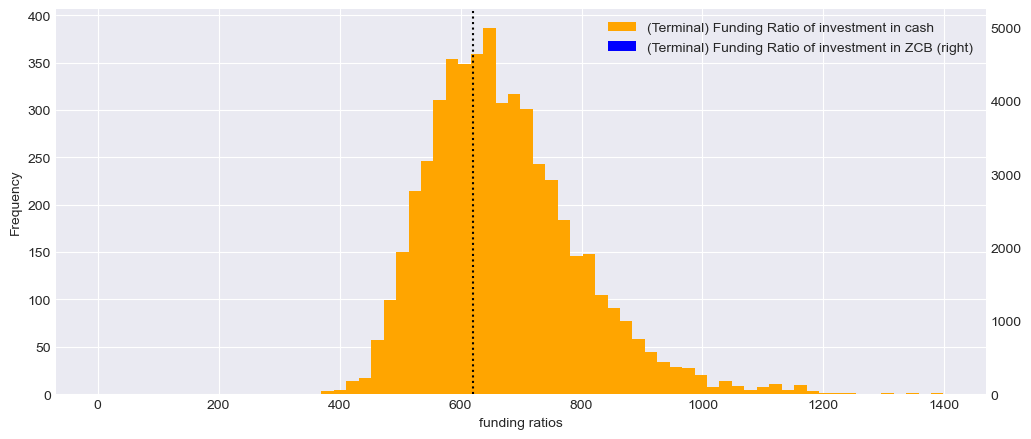

In [307]:
ax = terminal_fr_cash.plot.hist(label="(Terminal) Funding Ratio of investment in cash", bins=50, figsize=(12,5), color="orange", legend=True)
terminal_fr_zcb.plot.hist(ax=ax, grid=True, label="(Terminal) Funding Ratio of investment in ZCB", bins=50, legend=True, color="blue", secondary_y=True)
ax.axvline(x=620.0, linestyle=":", color="k")
ax.set_xlabel("funding ratios")
plt.show()

This shows that although there are many scenarios in which we can do very well with cash, i.e., our investment in cash will gain enough value to pay the liability (funding ratios larger than ), there are also many scenarios for which the funding ratio will be less than Total Liabilities. On the other hand, the terminal funding ratio for the investment of zero-coupon bond will be always larger than or equal to TL

# Coupon-bearing bonds

Differently from a zero-coupon bond which have only one cash flow consisting of the principal (face value, or par value) invested plus the interest accrued, a "regular" coupon-bearing bond pays coupons at regular intervals during the entire maturity. The last cash flow consists of the last coupon plus the principal:

In [334]:
principal        = 100 
maturity         = 5
ytm              = 0.05
coupon_rate      = 0.03 
coupons_per_year = 1

In [335]:
cf = kit.bond_cash_flows(principal=principal, maturity=maturity, coupon_rate=coupon_rate, coupons_per_year=coupons_per_year)
cf

,0
1,3.0
2,3.0
3,3.0
4,3.0
5,103.0


In [336]:
bond_price = kit.bond_price(principal=principal, maturity=maturity, coupon_rate=coupon_rate, coupons_per_year=coupons_per_year, ytm=ytm)
bond_price

91.34104665873834

In [337]:
# total sum paid by the bond if held until maturity 
tot_bond_paym = cf.sum()[0]
tot_bond_paym

115.0

In [338]:
# gain (in money) of the investment in such bond
gain = -bond_price + tot_bond_paym
gain

23.658953341261665

In [332]:
# tot_bond_paym = bond_price * (1 + r)**maturity, hence 
r = (tot_bond_paym / bond_price )**(1/maturity) - 1
r

0.04714391005077068

Basically, the YTM 4.7% is approximately given by the annual rate which (after compounding) returns a total amount equal to tot_bond_paym by having investing an initial amount equal to the bond price bond_price, i.e,

# Relation between yield to maturity and bond price

When the price of the bond is less than its face value (par value), the bond is selling at a discount. This happens when the ytm is larger than the coupon rate.
Conversely, if the price of the bond is greater than its face value, the bond is selling at a premium. This happens when the ytm is smaller than the coupon rate.
If the price of the bond is equal to its face value, the bond is selling at par. This happens when the ytm is equal to the coupon rate.
Therefore, the ytm and the bond price is inversely correlated:

In [339]:
# bond selling at discount: bond price smaller than face value
kit.bond_price(principal=100, maturity=5, coupon_rate=0.06, coupons_per_year=2, ytm=0.05)

104.37603196548555

In [341]:
# bond selling at premium: bond price larger than face value
kit.bond_price(principal=100, maturity=5, coupon_rate=0.06, coupons_per_year=2, ytm=0.02)

118.94260906140335

In [342]:
# bond selling at par: bond price equal to face value
kit.bond_price(principal=100, maturity=5, coupon_rate=0.06, coupons_per_year=2, ytm=0.03)

113.83327682778175

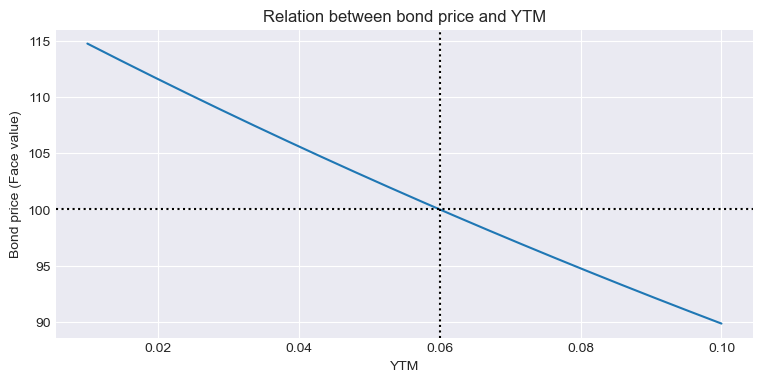

In [343]:
coupon_rate = 0.06
principal = 100
ytm = np.linspace(0.01, 0.10, 20)
bond_prices = [kit.bond_price(maturity=3, principal=principal, coupon_rate=coupon_rate, coupons_per_year=2, ytm=r) for r in ytm]

ax = pd.DataFrame(bond_prices, index=ytm).plot(grid=True, title="Relation between bond price and YTM", figsize=(9,4), legend=False)
ax.axvline(x=coupon_rate, linestyle=":", color="black")
ax.axhline(y=principal, linestyle=":", color="black")
ax.set_xlabel("YTM")
ax.set_ylabel("Bond price (Face value)")
plt.show()

Changes in price

Note that the yield to maturity is a variable that changes over time. In fact, it is an interest rate which changes and, in turn, would change the price of the bond.
Let us see how the price of a coupon-bearing bond changes as interest rates (i.e., yields to maturity) change. First of all, we simulate the interest rates usig the CIR model:

In [345]:
n_years          = 10
n_scenarios      = 10
b                = 0.03
periods_per_year = 2

rates, _ = kit.simulate_cir(n_years=n_years, n_scenarios=n_scenarios, a=0.02, b=b, sigma=0.02, periods_per_year=periods_per_year)
rates.tail()

,0,1,2,3,4,5,6,7,8,9
16,0.029356,0.035823,0.023154,0.041744,0.018770,0.032706,0.031108,0.028464,0.046695,0.022243
17,0.025948,0.036985,0.020137,0.042598,0.016850,0.034611,0.031222,0.031477,0.045756,0.022088
18,0.025239,0.038880,0.018251,0.046382,0.017727,0.039170,0.034002,0.030283,0.039651,0.019120
19,0.023576,0.038526,0.016767,0.043533,0.017694,0.035288,0.032311,0.032461,0.037336,0.017730
20,0.021347,0.040484,0.016697,0.042656,0.017933,0.032389,0.033921,0.031427,0.035565,0.017797


In [346]:
# bond features
principal        = 100
maturity         = n_years
coupon_rate      = 0.04
coupons_per_year = periods_per_year

bond_prices = kit.bond_price(principal=principal, maturity=maturity, coupon_rate=coupon_rate, 
                             coupons_per_year=coupons_per_year, ytm=rates) 

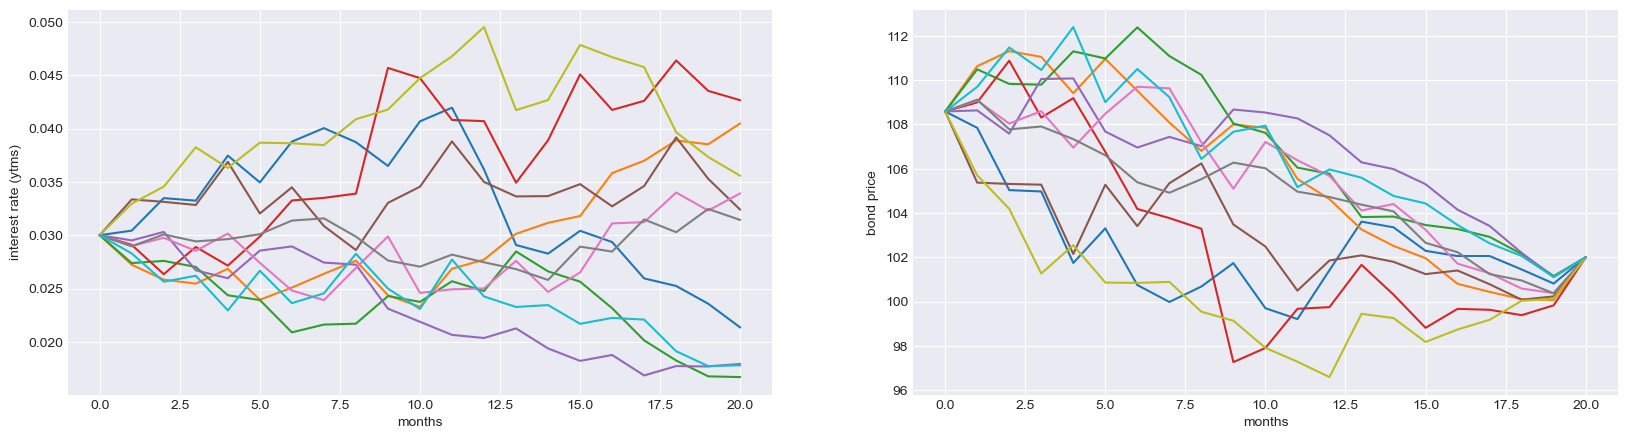

In [347]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
rates.plot(ax=ax[0], grid=True, legend=False) 
bond_prices.plot(ax=ax[1], grid=True, legend=False)
ax[0].set_xlabel("months")
ax[0].set_ylabel("interest rate (ytms)")
ax[1].set_xlabel("months")
ax[1].set_ylabel("bond price")
plt.show()

On the left, we see how interest rates changes over time, and on the right, we see how, in turn, the bond price changes as well. Also notice that, the price of the bonds at maturity is the same in all scenarios as it is given by the principal plus the coupon-interest.

Total return of a coupon-bearing bond
There is a curious thing to notice. What are the total returns of these bonds? If we simply compute the return by looking at the changes in prices of the bond we would get something weird:

In [348]:
# computing return by percentage changes in price
bond_rets = bond_prices.pct_change().dropna()
# and annualize the returns
kit.annualize_rets(bond_rets, periods_per_year=periods_per_year)

0   -0.006236
1   -0.006236
2   -0.006236
3   -0.006236
4   -0.006236
5   -0.006236
6   -0.006236
7   -0.006236
8   -0.006236
9   -0.006236
dtype: float64

In [369]:
bond_rets = kit.bond_returns(principal=principal, bond_prices=bond_prices, coupon_rate=coupon_rate, 
                             coupons_per_year=coupons_per_year, periods_per_year=periods_per_year)
kit.annualize_rets(bond_rets, periods_per_year=periods_per_year)

0    0.033055
1    0.031764
2    0.031373
3    0.032960
4    0.031482
5    0.032816
6    0.031836
7    0.032106
8    0.033856
9    0.031440
dtype: float64

In [370]:
# choose a fixed ytm
ytm = 0.035
b_price = kit.bond_price(principal=principal, maturity=maturity, coupon_rate=coupon_rate, coupons_per_year=coupons_per_year, ytm=ytm) 

b_ret = kit.bond_returns(principal=principal, bond_prices=b_price, coupon_rate=coupon_rate, 
                         coupons_per_year=coupons_per_year, periods_per_year=periods_per_year, maturity=maturity)

print("Bond price:  {:.6f}".format(b_price))
print("Bond return: {:.6f}".format(b_ret))

Bond price:  104.188220
Bond return: 0.029985


# Macaulay Duration

The Macaulay duration is the weighted average maturity of cash flows. Suppose the case of a bond. We have a set of fixed cash flows (the coupon payments and the last payment given by the principal) whose total present value is given by

In [380]:
principal        = 1000
maturity         = 3
ytm              = 0.06
coupon_rate      = 0.06
coupons_per_year = 1

In [381]:
cf = kit.bond_cash_flows(principal=principal, maturity=maturity, coupon_rate=coupon_rate, coupons_per_year=coupons_per_year)
cf

,0
1,60.0
2,60.0
3,1060.0


In [382]:
# the discount rate is the YTM divided by the coupons_per_year
macd = kit.mac_duration(cf, discount_rate=ytm/coupons_per_year) 
macd = macd / coupons_per_year
macd

2.833392666429334

that is, the duration of the bond is about XX  years versus the real maturity of XX  years. Note that we have divided by the number of coupons per year because the returned duration was computed with dates from 1 to 6, hence it was about  (this is the duration expressed in the number of total periods).

Another way to compute the duration would be to normalize the cash flows dates:

In [383]:

cf = kit.bond_cash_flows(principal=principal, maturity=maturity, coupon_rate=coupon_rate, coupons_per_year=coupons_per_year)
cf.index = cf.index / coupons_per_year
cf

,0
1.0,60.0
2.0,60.0
3.0,1060.0


In [384]:

# and now the discount rate is simply the YTM
kit.mac_duration(cf, discount_rate=ytm)

2.833392666429334

In [386]:
# ZCB: only one flux at maturity
maturity = 3
cf = pd.DataFrame(data=[100], index=[maturity])
macd = kit.mac_duration(cf, discount_rate=0.05) 
macd

3.0

# Liability Driven Investing (LDI)

Duration matching portfolios

What we want to see is how to construct a portfolio of bonds that has the same duration of the duration of a liability that we have for the future. Suppose we currently have an asset whose value is:

In [524]:
asset_value = 100000
interest_rate = 0.05

L = pd.DataFrame([620,100], index=[17.5,20])
L

,0
17.5,620
20.0,100


In [525]:
macd_liab = kit.mac_duration(L, discount_rate=interest_rate)
print("Liability duration: {:.3f} years".format(macd_liab))

Liability duration: 17.812 years


In the example, we have two equal payments in  and  years, respectively, and the duration of this liability is about  years.

Now, if we could buy a zero-coupon bond paying back the liability with a duration of about  years, that would be great since we know that we would have enough money to meet the liability.

On the other hand, suppose that such bond is diffcult to find. It is much easier to find a single regular coupon-bearing bonds: let us assume that, in the market, there are only 10-years and 20-years bonds we can invest in:

In [546]:
principal = 100000

# we assume a flat yield curve, i.e., the YTM of the short and long bond are equal (equal to the interest rate defined above)
maturity_short         = 5
coupon_rate_short      = 0.05
coupons_per_year_short = 1
ytm_short              = interest_rate

maturity_long         = 20
coupon_rate_long      = 0.08
coupons_per_year_long = 1
ytm_long              = interest_rate

Duration of chosen bonds

In [547]:
# we firstly get the cashflows of the bonds
cf_short = kit.bond_cash_flows(principal=principal, maturity=maturity_short, 
                               coupon_rate=coupon_rate_short, coupons_per_year=coupons_per_year_short)
cf_long  = kit.bond_cash_flows(principal=principal, maturity=maturity_long, 
                               coupon_rate=coupon_rate_long, coupons_per_year=coupons_per_year_long)

In [548]:

macd_short = kit.mac_duration(cf_short, discount_rate=ytm_short /coupons_per_year_short) /coupons_per_year_short
macd_long  = kit.mac_duration(cf_long,  discount_rate=ytm_long  /coupons_per_year_long)  /coupons_per_year_long
print("(Short) bond duration: {:.3f} years".format(macd_short))
print("(Long) bond duration:  {:.3f} years".format(macd_long))

(Short) bond duration: 4.546 years
(Long) bond duration:  11.947 years


In [549]:
macd_long

11.947188353204002

In [550]:
# weight in the short bond
w_short = (macd_liab - macd_long) / (macd_short - macd_long)
w_short

-0.7924544195438548

In [551]:
# Compute the bonds prices
bondprice_short = kit.bond_price(principal=principal, maturity=maturity_short, coupon_rate=coupon_rate_short, 
                                 coupons_per_year=coupons_per_year_short, ytm=ytm_short)
bondprice_long  = kit.bond_price(principal=principal, maturity=maturity_long, coupon_rate=coupon_rate_long, 
                                 coupons_per_year=coupons_per_year_long, ytm=ytm_long)
print("(Short) Bond price: {:.2f}".format(bondprice_short))
print("(Long) Bond price: {:.2f}".format(bondprice_long))

(Short) Bond price: 100000.00
(Long) Bond price: 137386.63


In [552]:
# the number of short bond that we can buy (analogously for the long bond):
# n_bond_short * bondprice_short = w_short * asset_value ==>  n_bond_short = w_short * asset_value / bondprice_short 
portfolio_cf_short = w_short     * asset_value / bondprice_short * cf_short
portfolio_cf_long  = (1-w_short) * asset_value / bondprice_long  * cf_long

# cashflows of the short and long bond
portfolio_cf = pd.concat([portfolio_cf_short, portfolio_cf_long], axis=1).fillna(0)        
portfolio_cf.columns = ["CF short", "CF long"]

# adding the cashflow of the portfolio
portfolio_cf["CF portfolio"] = portfolio_cf.sum(axis=1)
portfolio_cf

,CF short,CF long,CF portfolio
1,-3962.272098,10437.431393,6475.159295
2,-3962.272098,10437.431393,6475.159295
3,-3962.272098,10437.431393,6475.159295
4,-3962.272098,10437.431393,6475.159295
5,-83207.714052,10437.431393,-72770.282659
6,0.000000,10437.431393,10437.431393
7,0.000000,10437.431393,10437.431393
8,0.000000,10437.431393,10437.431393
9,0.000000,10437.431393,10437.431393
10,0.000000,10437.431393,10437.431393


In [553]:
# make the portfolio cf a dataframe
portfolio_cf = pd.DataFrame(portfolio_cf["CF portfolio"])
portfolio_cf.columns = [0]

macd_portfolio = kit.mac_duration(portfolio_cf, discount_rate=interest_rate)
macd_portfolio

17.812331996772294

In [554]:
def funding_ratio(asset_value, liabilities, r):

    return kit.present_value(asset_value, r) / kit.present_value(liabilities, r)   

In [555]:
# remove weights from series of cashflows 
short_bond_asset = asset_value / bondprice_short * cf_short
long_bond_asset  = asset_value / bondprice_long * cf_long

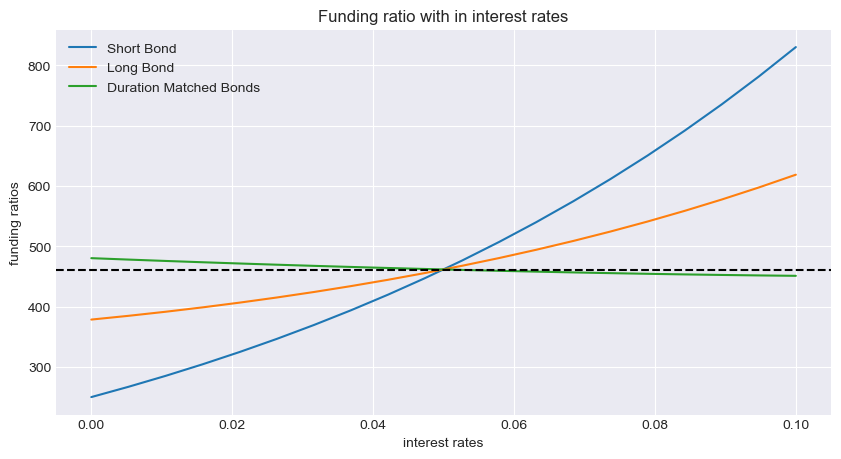

In [561]:
# interest rates
rates = np.linspace(0, 0.1, 20)

fun_ratios = pd.DataFrame(
    {
        "Short Bond": [funding_ratio(short_bond_asset, L, r)[0] for r in rates],
        "Long Bond": [funding_ratio(long_bond_asset, L, r)[0] for r in rates],
        "Duration Matched Bonds": [funding_ratio(portfolio_cf, L, r)[0] for r in rates]
    }, index = rates
)

ax = fun_ratios.plot(grid=True, figsize=(10,5), title="Funding ratio with in interest rates")
ax.set_xlabel("interest rates")
ax.set_ylabel("funding ratios")
ax.axhline(y=460, linestyle="--", c="k")
plt.show()

We observe that as long as interest rates are smaller than the liability rate, investing all of our money in the long bond would guarantee a funding ratio larger than . When they start to increase, we see that we would not have enough funding to meet the liability.

The opposite occurs in the case of investing all of our money in the short bond.

On the other hand, we see that investing in the matching duration portfolio guarantees a funding ratio larger than (or equal to)  no matter how interest rates change.

In [562]:
def duration_match_weight(d1, d2, d_liab):
    w1 = (d_liab - d2) / (d1 - d2)
    w2 = 1 - w1
    return w1, w2

In [563]:
flat_yield = 0.05

In [564]:
L = pd.DataFrame([420000,15000,65000], index=[17,17.5,18])
L

,0
17.0,420000
17.5,15000
18.0,65000


In [565]:
macd_L = kit.mac_duration(L, discount_rate=flat_yield)
macd_L

17.139411845070217

In [587]:
principal = 1000000

maturity_b1         = 20
coupon_rate_b1      = 0.05
ytm_b1              = flat_yield
coupons_per_year_b1 = 1

maturity_b2         = 15
coupon_rate_b2      = 0.06
ytm_b2              = flat_yield
coupons_per_year_b2 = 1

In [588]:
cf_b1 = kit.bond_cash_flows(principal=principal, maturity=maturity_b1, coupon_rate=coupon_rate_b1, coupons_per_year=coupons_per_year_b1)
cf_b2 = kit.bond_cash_flows(principal=principal, maturity=maturity_b2, coupon_rate=coupon_rate_b2, coupons_per_year=coupons_per_year_b2)
cf_b1.index = cf_b1.index / coupons_per_year_b1
cf_b2.index = cf_b2.index / coupons_per_year_b2

In [589]:
macd_b1 = kit.mac_duration(cf_b1,discount_rate=ytm_b1) 
macd_b1

13.085320859666986

In [590]:
macd_b2 = kit.mac_duration(cf_b2,discount_rate=ytm_b2)
macd_b2

10.541179453382568

In [591]:
w_b1, w_b2 = duration_match_weight(macd_b1, macd_b2, macd_L)
w_b1, w_b2

(2.5935006503133073, -1.5935006503133073)

In [592]:
bprice_b1 = kit.bond_price(principal=principal, maturity=maturity_b1, coupon_rate=coupon_rate_b1, 
                           coupons_per_year=coupons_per_year_b1, ytm=ytm_b1)
bprice_b2 = kit.bond_price(principal=principal, maturity=maturity_b2, coupon_rate=coupon_rate_b2, 
                           coupons_per_year=coupons_per_year_b2, ytm=ytm_b2)
(bprice_b1, bprice_b2) 

(999999.9999999993, 1103796.5803818055)

In [593]:
asset_value = 100000 # does not matter this value

In [594]:
# the number of short bond that we can buy (analogously for the long bond):
# n_bond_short * bondprice_short = w_short * asset_value ==>  n_bond_short = w_short * asset_value / bondprice_short 
portfolio_cf_b1 = w_b1 * asset_value / bprice_b1 * cf_b1
portfolio_cf_b2 = w_b2 * asset_value / bprice_b2 * cf_b2

# cashflows of the short and long bond
portfolio_cf = pd.concat([portfolio_cf_b1, portfolio_cf_b2], axis=1).fillna(0)        
portfolio_cf.columns = ["CF b1", "CF b2"]

# adding the cashflow of the portfolio
portfolio_cf["CF portfolio"] = portfolio_cf.sum(axis=1)
portfolio_cf

,CF b1,CF b2,CF portfolio
1.0,12967.503252,-8661.925641,4305.577611
2.0,12967.503252,-8661.925641,4305.577611
3.0,12967.503252,-8661.925641,4305.577611
4.0,12967.503252,-8661.925641,4305.577611
5.0,12967.503252,-8661.925641,4305.577611
6.0,12967.503252,-8661.925641,4305.577611
7.0,12967.503252,-8661.925641,4305.577611
8.0,12967.503252,-8661.925641,4305.577611
9.0,12967.503252,-8661.925641,4305.577611
10.0,12967.503252,-8661.925641,4305.577611


In [595]:
# make the portfolio cf a dataframe
portfolio_cf = pd.DataFrame(portfolio_cf["CF portfolio"].rename(0))

macd_portfolio = kit.mac_duration(portfolio_cf, discount_rate=flat_yield)  #w_b1*ytm_b1 + w_b2*ytm_b2)
macd_portfolio

17.13941184507021

In [596]:
macd_L

17.139411845070217

# Performance-Seeking Portfolio and Liability-Hedging Portfolio (PSP/LHP)

Under the paradigm of Liability Driven Investing (LDI), we may have a portfolio consisting of different assets.

In particular, the portfolio may consist of two portfolios, one portfolio whose focus is the profit, hence on diversified and efficient access to risk premia, and a second portfolio whose aim is the liability hedging. The first portfolio is called Performance-Seeking Portfolio (PSP) whereas the second one is called Liability-Hedging Portfolio (LHP).

An investor should then be holding two separate building blocks, one dedicated to performace and one dedicated to hedging.

In the section above, we focused on the liability-hedging part of of LDI strategy. In fact, we constructed a portfolio consisting of bonds whose aim was to hedge against the liability that we had (such LHP was constructed by matching the duration of the liability).

Naive PSP/LHP weigthing strategy

A simple form of the LDI strategy is a fixed-mix combination of the two building blocks, in which the allocation to the PSPis adjusted in order to reach a target relative to risk level.

In what follows, we try to mix a LHP portfolio consisting of, e.g., bonds, with a PSP portfolio consisting of, e.g., stocks, by using a fixed-mix strategy. That is, we fix the allocation weights beforehand.

First of all, suppose we have a set of two bond to invest in. They are a short-term (10 years) and a long-term (20 years) bonds:

In [658]:
principal = 100

maturity_short         = 10
coupon_rate_short      = 0.05
coupons_per_year_short = 2

maturity_long          = 20
coupon_rate_long       = 0.07
coupons_per_year_long  = 2

In [659]:
n_scenarios      = 1000
n_years          = np.max([maturity_short, maturity_long]) # = maturity_long
mean_rate        = 0.03
periods_per_year = 2

# simulate rates and zero-coupon prices
rates, zcb_price = kit.simulate_cir(n_years=n_years, n_scenarios=n_scenarios, a=0.05, b=mean_rate, 
                                    sigma=0.02, periods_per_year=periods_per_year)
rates.tail()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
36,0.027643,0.027243,0.040676,0.018808,0.025861,0.049502,0.046702,0.041437,0.026701,0.025546,...,0.022118,0.030527,0.039440,0.037993,0.031113,0.041557,0.039750,0.033422,0.019819,0.010879
37,0.028541,0.026838,0.043787,0.016855,0.028570,0.048381,0.048826,0.048288,0.025572,0.021967,...,0.020423,0.031881,0.041114,0.042171,0.030262,0.036670,0.037790,0.028221,0.020455,0.013462
38,0.030302,0.028849,0.047179,0.018605,0.029279,0.048307,0.048145,0.047020,0.026278,0.022750,...,0.023679,0.034370,0.039391,0.043271,0.030250,0.039692,0.035197,0.028075,0.018041,0.014716
39,0.027299,0.029401,0.044629,0.015996,0.030398,0.048748,0.046123,0.039551,0.025912,0.023990,...,0.021593,0.032469,0.038012,0.047050,0.031123,0.031921,0.035105,0.027155,0.018778,0.015281
40,0.030423,0.025677,0.041972,0.020032,0.032023,0.047050,0.048767,0.042502,0.024582,0.024192,...,0.019825,0.033981,0.032198,0.048623,0.029695,0.034845,0.032295,0.024543,0.019237,0.018567


In [660]:
l = int(coupons_per_year_short * n_years / periods_per_year)

bond_pr_short = kit.bond_price(principal=principal, maturity=maturity_short, coupon_rate=coupon_rate_short, 
                               coupons_per_year=coupons_per_year_short, ytm=rates.iloc[:l+1,:]) 

bond_pr_long = kit.bond_price(principal=principal, maturity=maturity_long, coupon_rate=coupon_rate_long, 
                              coupons_per_year=coupons_per_year_long, ytm=rates).iloc[:l+1,:]

In [661]:
bond_rets_short = kit.bond_returns(principal=principal, bond_prices=bond_pr_short, coupon_rate=coupon_rate_short, 
                                   coupons_per_year=coupons_per_year_short, periods_per_year=periods_per_year)

bond_rets_long = kit.bond_returns(principal=principal, bond_prices=bond_pr_long, coupon_rate=coupon_rate_long, 
                                   coupons_per_year=coupons_per_year_long, periods_per_year=periods_per_year)

We are now ready to buid the LHP which consists of a fixed-mix of the two bonds. The return fo such portfolio is given by the weighted sum of the returns of the two bonds.

Below we choose a 60/40 allocation, i.e., we invest  in the short-term bond and  in the long-term bond (these percentage are relative to the percentage of the investment dedicated to the LHP):

In [662]:
w1 = 0.6
bond_rets = kit.ldi_mixer(bond_rets_short, bond_rets_long, allocator=kit.ldi_fixed_allocator, w1=w1)
bond_rets.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1,-0.006968,0.032039,-0.024075,0.018307,-0.007542,0.01251,0.026424,-0.017456,0.022239,0.020366,...,0.012516,0.013091,-0.010758,0.022953,0.022198,0.026732,0.032400,0.013749,-0.001815,0.019498
2,0.044564,0.034384,0.017055,-0.034845,0.028092,0.01918,-0.038519,0.024682,0.017767,0.040914,...,0.062378,0.001857,0.014519,0.013136,0.030892,0.001096,-0.007729,0.017020,0.004564,-0.011258
3,0.047099,-0.039497,0.018105,-0.001488,0.006596,-0.02127,0.046593,-0.003565,-0.024167,0.024022,...,0.006105,0.018255,-0.030836,-0.020206,0.035019,0.032324,0.009910,0.030336,0.030235,0.039933
4,0.022716,0.014547,0.007631,0.018153,0.011627,0.01963,0.030316,0.028981,0.002644,0.016715,...,-0.021722,0.005177,0.067871,0.016648,0.003585,0.013618,0.042794,-0.007417,-0.026630,0.044823
5,0.048985,0.020810,0.048262,0.021302,0.018356,0.03101,0.004654,0.043748,0.053797,0.001169,...,-0.031480,0.045404,0.015534,0.069999,0.019645,0.003909,0.010987,-0.008052,0.035428,0.022843


 The dataframe above contains all scenarios of returns of a (60/40 allocation) liability-hedging portfolio consisting of the two bonds.
 
 Below is the PSP consisting of stocks, where stock are generated via random walks:

In [663]:
stock_price, stock_rets = kit.simulate_gbm_from_prices(n_years=maturity_short, n_scenarios=n_scenarios, 
                                                       mu=0.07, sigma=0.1, periods_per_year=2, start=100.0)

Fixed-Mixed allocation

We can now construct the PSP/LHP strategy via a fixed mixed allocation between stocks and bonds.

For example, we can decide to assign a 70/30 allocation rule during the entire life of the investment, i.e., 70% allocated in the diversified portfolio of stocks and 30% allocated in the portfolio of bonds:

In [667]:
# 70/30 Stocks/Bonds
w1 = 0.7
stock_bond_rets = kit.ldi_mixer(stock_rets, bond_rets, allocator=kit.ldi_fixed_allocator, w1=w1)
stock_bond_rets.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1,0.028205,0.059166,0.087558,0.089000,0.024356,0.071039,0.001787,-0.000959,0.088921,-0.017328,...,0.082055,0.044297,0.030951,0.121010,-0.023113,0.027380,0.013114,-0.014574,0.080517,0.114478
2,0.051229,0.072399,0.030724,0.000812,0.083570,0.016422,0.103838,0.057969,0.058427,0.041764,...,0.040982,0.067391,0.074105,0.044346,-0.013918,0.002567,0.125099,0.004308,0.050211,-0.011443
3,0.033885,0.041672,0.048395,0.038624,0.096818,0.021117,0.047092,0.074474,-0.032780,0.000752,...,0.006333,-0.045675,0.047124,0.056071,0.050046,-0.059051,0.007838,0.034532,-0.042082,0.029397
4,0.084980,-0.089733,0.130922,0.068367,0.059520,0.051617,0.093106,0.042966,0.095603,0.051153,...,0.025109,0.103190,0.084533,0.015323,0.030093,-0.042150,-0.033353,0.077662,0.046390,-0.050144
5,-0.005145,0.005220,-0.026022,-0.043608,-0.050392,0.125975,0.022468,-0.004600,0.111960,0.092522,...,0.192040,-0.023654,0.069916,0.077988,0.062484,-0.003745,0.049475,0.076664,-0.017176,-0.006777


In [668]:
stock_bond_rets_stats = kit.summary_stats(stock_bond_rets, risk_free_rate=0, periods_per_year=2)
stock_bond_rets_stats.tail()

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
995,0.052376,0.076475,0.684879,0.692268,3.241043,0.059051,0.048414,-0.102087
996,0.061206,0.070820,0.864239,0.577940,2.613445,0.043330,0.041055,-0.054698
997,0.075468,0.068151,1.107364,0.647088,2.721311,0.037324,0.030422,-0.037324
998,0.038580,0.084620,0.455923,-1.134850,4.472406,0.150979,0.090741,-0.150979
999,0.052351,0.072239,0.724686,-0.372539,2.471344,0.081600,0.060501,-0.081600


Summary stats of PSP/LHP portfolio strategy. On average all scenarios give about 5% annualized return

In [670]:
stock_bond_rets_stats.mean()

Ann. return      0.053686
Ann. vol         0.069618
Sharpe ratio     0.796438
Skewness         0.007566
Kurtosis         2.763522
Historic CVar    0.065908
C-F Var          0.051245
Max Drawdown    -0.086311
dtype: float64

In [674]:
floor = 0.8
ldi_stats = pd.concat([
    kit.summary_stats_terminal(bond_rets, floor=floor, periods_per_year=periods_per_year, name="Bonds only"),
    kit.summary_stats_terminal(stock_rets, floor=floor, periods_per_year=periods_per_year, name="Stocks only"),
    kit.summary_stats_terminal(stock_bond_rets, floor=floor, periods_per_year=periods_per_year, name="70/30 Stocks/Bonds"),
], axis=1)
ldi_stats

,Bonds only,Stocks only,70/30 Stocks/Bonds
Mean ann. ret.,0.031768,0.061709,0.053686
Mean wealth,1.367341,1.901634,1.723734
Mean wealth std,0.023370,0.613222,0.384341
Prob breach,0.000000,0.004000,0.000000
Exp shortfall,0.000000,0.034635,0.000000


The table above show that investing only in bonds would result in no probability of beaching the floor. On the other hand, it may happen that both investments in stocks and in the mixed PSP/LHP have some probability (on average) of breaching the floor (it is certainly probable for single stock investment). As expected, the mixed PSP/LHP is however more accountable: the return is a halfway between the PSP (stocks) and the LHP (bonds) as well as the final wealth generated (on average).

C:\Users\Feliks.Chilingaryan\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Feliks.Chilingaryan\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Feliks.Chilingaryan\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

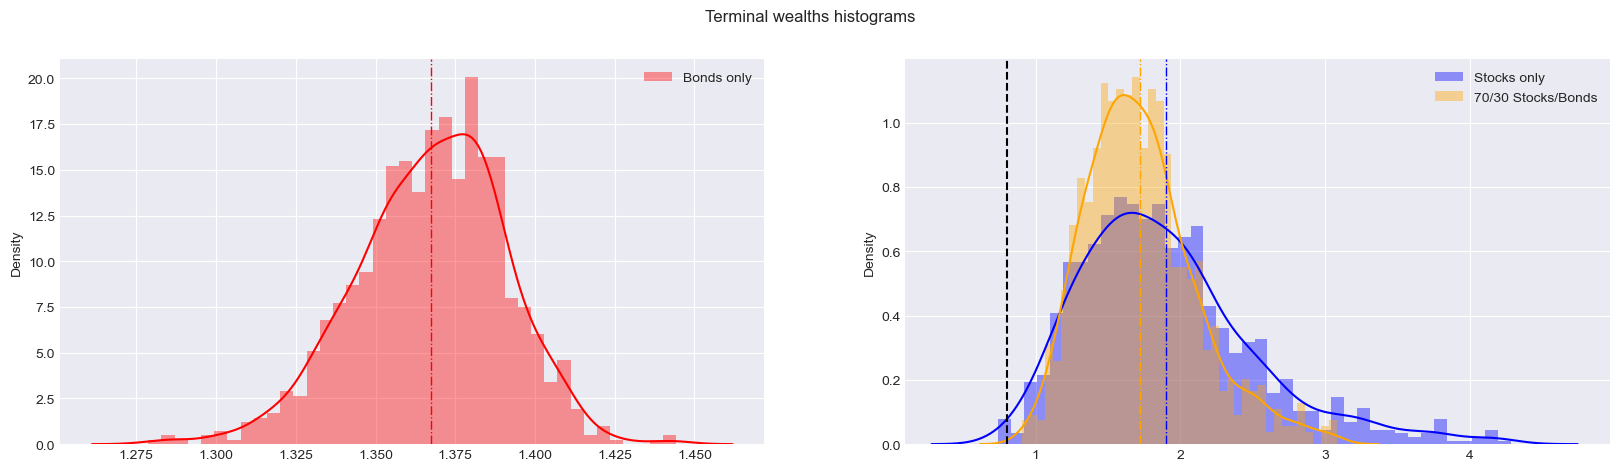

In [675]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot( kit.terminal_wealth(bond_rets), bins=40, color="red", label="Bonds only", ax=ax[0]) 
sns.distplot( kit.terminal_wealth(stock_rets), bins=40, color="blue", label="Stocks only", ax=ax[1])
sns.distplot( kit.terminal_wealth(stock_bond_rets), bins=40, color="orange", label="70/30 Stocks/Bonds", ax=ax[1])
plt.suptitle("Terminal wealths histograms")
ax[0].axvline( x=kit.terminal_wealth(bond_rets).mean(), linestyle="-.", color="red", linewidth=1)
ax[1].axvline( x=kit.terminal_wealth(stock_rets).mean(), linestyle="-.", color="blue", linewidth=1)
ax[1].axvline( x=kit.terminal_wealth(stock_bond_rets).mean(), linestyle="-.", color="orange", linewidth=1)
ax[1].axvline( x=floor, linestyle="--", color="k")
ax[1].set_xlim(left=0.1) 
ax[0].legend(), ax[0].grid()
ax[1].legend(), ax[1].grid()
plt.show()

In the plot above, we can see an histogram of the terminal wealths and visually see in the plot on the right that in both cases of simple PSP (stocks) and PSP/LHP (stocks/bond) there may be some terminal wealths that breach the given floor.

# Weight allocation

Instead of using fixed weigth allocation throughout the entire life of the investment strategy, we can still use a fixed weigthing allocation that, however, changes over time and for example, rebalances the weights allocated to the PSP.

For instance, we may start with a 80/20 allocation in stocks/bond and finishing with (i.e., at maturity) a 20/80 in stocks bond:

In [677]:
kit.ldi_glidepath_allocator(stock_rets, bond_rets, start=0.8, end=0.2)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,...,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000
2,0.768421,0.768421,0.768421,0.768421,0.768421,0.768421,0.768421,0.768421,0.768421,0.768421,...,0.768421,0.768421,0.768421,0.768421,0.768421,0.768421,0.768421,0.768421,0.768421,0.768421
3,0.736842,0.736842,0.736842,0.736842,0.736842,0.736842,0.736842,0.736842,0.736842,0.736842,...,0.736842,0.736842,0.736842,0.736842,0.736842,0.736842,0.736842,0.736842,0.736842,0.736842
4,0.705263,0.705263,0.705263,0.705263,0.705263,0.705263,0.705263,0.705263,0.705263,0.705263,...,0.705263,0.705263,0.705263,0.705263,0.705263,0.705263,0.705263,0.705263,0.705263,0.705263
5,0.673684,0.673684,0.673684,0.673684,0.673684,0.673684,0.673684,0.673684,0.673684,0.673684,...,0.673684,0.673684,0.673684,0.673684,0.673684,0.673684,0.673684,0.673684,0.673684,0.673684
6,0.642105,0.642105,0.642105,0.642105,0.642105,0.642105,0.642105,0.642105,0.642105,0.642105,...,0.642105,0.642105,0.642105,0.642105,0.642105,0.642105,0.642105,0.642105,0.642105,0.642105
7,0.610526,0.610526,0.610526,0.610526,0.610526,0.610526,0.610526,0.610526,0.610526,0.610526,...,0.610526,0.610526,0.610526,0.610526,0.610526,0.610526,0.610526,0.610526,0.610526,0.610526
8,0.578947,0.578947,0.578947,0.578947,0.578947,0.578947,0.578947,0.578947,0.578947,0.578947,...,0.578947,0.578947,0.578947,0.578947,0.578947,0.578947,0.578947,0.578947,0.578947,0.578947
9,0.547368,0.547368,0.547368,0.547368,0.547368,0.547368,0.547368,0.547368,0.547368,0.547368,...,0.547368,0.547368,0.547368,0.547368,0.547368,0.547368,0.547368,0.547368,0.547368,0.547368
10,0.515789,0.515789,0.515789,0.515789,0.515789,0.515789,0.515789,0.515789,0.515789,0.515789,...,0.515789,0.515789,0.515789,0.515789,0.515789,0.515789,0.515789,0.515789,0.515789,0.515789


In [686]:
stock_bond_rets_glide = kit.ldi_mixer(stock_rets, bond_rets, allocator=kit.ldi_glidepath_allocator, start=0.8, end=0.2)
stock_bond_rets_glide.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1,0.033230,0.063041,0.103506,0.099099,0.028912,0.079400,-0.001732,0.001398,0.098446,-0.022713,...,0.091990,0.048755,0.036909,0.135018,-0.029586,0.027473,0.010359,-0.018620,0.092279,0.128046
2,0.051881,0.076114,0.032060,0.004298,0.088993,0.016153,0.117753,0.061222,0.062401,0.041847,...,0.038891,0.073797,0.079929,0.047396,-0.018298,0.002711,0.138083,0.003065,0.054673,-0.011461
3,0.033190,0.045944,0.049990,0.040736,0.101567,0.023347,0.047118,0.078581,-0.033233,-0.000473,...,0.006345,-0.049040,0.051227,0.060085,0.050837,-0.063861,0.007728,0.034753,-0.045888,0.028842
4,0.085448,-0.090518,0.131849,0.068745,0.059880,0.051857,0.093578,0.043071,0.096302,0.051411,...,0.025461,0.103927,0.084658,0.015313,0.030293,-0.042569,-0.033926,0.078301,0.046939,-0.050858
5,-0.003110,0.005806,-0.023229,-0.041168,-0.047807,0.122405,0.021798,-0.002782,0.109774,0.089088,...,0.183637,-0.021058,0.067872,0.077687,0.060874,-0.003457,0.048028,0.073480,-0.015198,-0.005663


In [696]:
floor = 0.8
ldi_stats = pd.concat([
    kit.summary_stats_terminal(bond_rets, floor=floor, periods_per_year=periods_per_year, name="Bonds only"),
    kit.summary_stats_terminal(stock_rets, floor=floor, periods_per_year=periods_per_year, name="Stocks only"),
    kit.summary_stats_terminal(stock_bond_rets, floor=floor, periods_per_year=periods_per_year, name="70/30 Stocks/Bonds"),
    kit.summary_stats_terminal(stock_bond_rets_glide, floor=floor, periods_per_year=periods_per_year, name="80/20 Stocks/Bonds"),
], axis=1)
ldi_stats

,Bonds only,Stocks only,70/30 Stocks/Bonds,80/20 Stocks/Bonds
Mean ann. ret.,0.206454,0.052626,0.378407,0.330152
Mean wealth,1.367341,1.851271,1.723734,1.617810
Mean wealth std,0.023370,0.941085,0.384341,0.272778
Prob breach,0.000000,0.058000,0.000000,0.000000
Exp shortfall,0.000000,0.144953,0.000000,0.000000


We see that this way of becoming less aggressive as soon as we approach the maturity may eventually result in a better strategy as (on average) we have not reached the floor in change of a slightly less return (and terminal wealth).

# Taking into account the floor

Mix of PSP/LHP strategies with the of ZCB as proxy

In [752]:
n_scenarios      = 1000
n_years          = 10
mean_rate        = 0.03
# generate monthly data
periods_per_year = 12 

# simulate rates and zero-coupon prices
rates, zcb_price = kit.simulate_cir(n_years=n_years, n_scenarios=n_scenarios, a=0.05, b=mean_rate, 
                                    sigma=0.02, periods_per_year=periods_per_year)

# computes the ZCB returns 
zcb_rets = zcb_price.pct_change().dropna()

# simulate stock prices (and returns)
stock_price, stock_rets = kit.simulate_gbm_from_prices(n_years=n_years, n_scenarios=n_scenarios, 
                                                       mu=0.07, sigma=0.15, periods_per_year=periods_per_year)

In [753]:
w1 = 0.7
stock_zcb_rets = kit.ldi_mixer(stock_rets, zcb_rets, allocator=kit.ldi_fixed_allocator, w1=w1)

In [754]:
floor = 0.8
ldi_stats = pd.concat([
    kit.summary_stats_terminal(zcb_rets, floor=floor, periods_per_year=periods_per_year, name="ZCB only"),
    kit.summary_stats_terminal(stock_rets, floor=floor, periods_per_year=periods_per_year, name="Stocks only"),
    kit.summary_stats_terminal(stock_zcb_rets, floor=floor, periods_per_year=periods_per_year, name="70/30 Stocks/ZCB"),
], axis=1).round(4)
ldi_stats

,ZCB only,Stocks only,70/30 Stocks/ZCB
Mean ann. ret.,0.0300,0.0511,0.0470
Mean wealth,1.3433,1.8214,1.6625
Mean wealth std,0.0000,0.9294,0.5716
Prob breach,0.0000,0.0640,0.0250
Exp shortfall,0.0000,0.1608,0.0819


As expected, investing only in the ZCB would result in a small return but zero probability of breaching the floor. On the other hand, the PSP/LHP strategy increases the performance although there is a small probability of breaching the floor.

Drawndown allocator

In [756]:
# use maxdd = 0.2
stock_zcb_dd_02_rets = kit.ldi_mixer(stock_rets, zcb_rets, allocator=kit.ldi_drawdown_allocator, maxdd=0.2)

In [757]:
# the floor, in case of the drawdown constraint, is given by 1 - maxdd
ldi_stats = pd.concat([
    ldi_stats,
    kit.summary_stats_terminal(stock_zcb_dd_02_rets, floor=1 - 0.2, periods_per_year=periods_per_year, name="DD(0.2) Stocks/ZCB"),
], axis=1).round(4)
ldi_stats

,ZCB only,Stocks only,70/30 Stocks/ZCB,DD(0.2) Stocks/ZCB
Mean ann. ret.,0.0300,0.0511,0.0470,0.0451
Mean wealth,1.3433,1.8214,1.6625,1.6438
Mean wealth std,0.0000,0.9294,0.5716,0.6504
Prob breach,0.0000,0.0640,0.0250,0.0000
Exp shortfall,0.0000,0.1608,0.0819,0.0000


Instead of using the ZCB as safe asset (i.e., as LHP), we could in principle invest in cash. Suppose we have the following monthly cash returns:

In [758]:
ann_cashrate = 0.02
monthly_cashrets = (1 + ann_cashrate)**(1/12) - 1
cash_rets = pd.DataFrame(data=monthly_cashrets, index=stock_rets.index, columns=stock_rets.columns)

In [760]:
# define maxdd = 0.2
stock_cash_dd_02_rets = kit.ldi_mixer(stock_rets, cash_rets, allocator=kit.ldi_drawdown_allocator, maxdd=0.2)

In [775]:
# the floor, in case of the drawdown constraint, is given by 1 - maxdd
ldi_stats = pd.concat([
    ldi_stats,
    kit.summary_stats_terminal(stock_cash_dd_02_rets, floor=1 - 0.2, periods_per_year=periods_per_year, name="DD(0.2) Stocks/Cash"),
], axis=1).round(4)
ldi_stats

,ZCB only,Stocks only,70/30 Stocks/ZCB,DD(0.2) Stocks/ZCB,DD(0.2) Stocks/Cash,DD(0.2) Stocks/Cash,DD(0.2) Stocks/Cash,DD(0.2) Stocks/Cash,DD(0.2) Stocks/Cash,DD(0.2) Stocks/Cash,DD(0.2) Stocks/Cash,DD(0.2) Stocks/Cash,DD(0.2) Stocks/Cash,DD(0.2) Stocks/Cash,DD(0.2) Stocks/Cash,DD(0.2) Stocks/Cash,DD(0.2) Stocks/Cash,DD(0.2) Stocks/Cash
Mean ann. ret.,0.0300,0.0511,0.0470,0.0451,0.0403,0.0403,0.0403,0.0403,0.0403,0.0403,0.0403,0.0403,0.0403,0.0403,0.0403,0.0403,0.0403,0.0403
Mean wealth,1.3433,1.8214,1.6625,1.6438,1.5724,1.5724,1.5724,1.5724,1.5724,1.5724,1.5724,1.5724,1.5724,1.5724,1.5724,1.5724,1.5724,1.5724
Mean wealth std,0.0000,0.9294,0.5716,0.6504,0.6330,0.6330,0.6330,0.6330,0.6330,0.6330,0.6330,0.6330,0.6330,0.6330,0.6330,0.6330,0.6330,0.6330
Prob breach,0.0000,0.0640,0.0250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Exp shortfall,0.0000,0.1608,0.0819,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


We can verify whether the maximum drawdown constraint worked fine by computing the maximum drawdown across all scenarios and looking at the minimum. Since we impose a maximum drawdown of , we expect to see the minimim drawdown 20% to be at most (or very close to) 0.2 :

In [776]:
kit.summary_stats(stock_cash_dd_02_rets)["Max Drawdown"].min()

-0.19453077979577005